*IMPORTANT NOTICE*

This notebook was developed in google colab, using the colab disk space to store data. This can manipulated using bash commands, which for convience can be operated from within the notebook and are delineated clearly with exclamation marks. (e.g ! bash command)

For the condition simulations I used the T4 GPU on colab, the following code cell shows the details of the GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar 29 13:06:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Investigating Moding Resilience to Different Conditions**

An important factor to consider when performing image classification using a neural network is the domain of possible inputs. For this specific task, the input images will come from small drone cameras or mounted CCTV cameras and similar such technologies. There are many reasons that could mean the input images are of low quality or have non standard features, some such examples are:

    - Strong winds (often associated with the spread of wildfires) may knock the camera out normal position causing rotations in the images.
    - Poor image pixel quality (degeneration) due to older technology, lense scratches, low bandwith and other similar reasons.
    - Brightness effects due to glare or camera settings.
    - Complete image capture failiure for certain frames in video footage.
    - Scenery; depends on the season / geography.

These factors were considered in the model trainig, for the most succesful attempt using all RBG channels, the following augmentation was applied to training images:

    - Random rotations
    - Random image flipping
    - Random contrast changes
    - Random brightness
    - Random colour degeneration

The purpose of this notebook is to test the resilience of the final model to augmented testing data simulating different aforementioned input qualities.

## **Task 1: Importing modules and data**

First the neccessary python modules must be imported and the data loaded and structured before being stored in TensorFlow datasets.

In [ ]:
#Import standard libraries and imageio to read in the images
import imageio.v3 as imageio

# Import numpy/itertools for array/maths calculations
import numpy as np
import itertools

# Import matplotlib to plot graphs etc.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

# Import pandas to manage datasets
import pandas as pd

# Import os/path lib to navigate the colab directory.
import os
import pathlib

# Import tensorflow and keras machine learning libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Import scikit metrics to evaluate models
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import google drive mounting module
from google.colab import drive

In [ ]:
# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/2024-2025/PHAS0056/Code'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/My Drive/2024-2025/PHAS0056/Code


In [ ]:
# Bash command to unzip the dataset
! unzip -qq fireNoFire.zip -d /data

replace /data/Training/Fire/resized_frame3034.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### **Dataset structuring**

In [ ]:
# Go to the root directory
os.chdir('/')

# Create new direcory
new_dir = os.path.join(os.getcwd(), 'Binary')
os.makedirs(new_dir)

# Move to new directory
os.chdir('/Binary/')



In [ ]:
# Copy the test data labelled as 'Fire' to the new Binary/ directory
! cp -r /data/Test/No_Fire .

! cp -r /data/Test/Fire .


In [ ]:
# Copy over manually selected non-lake images labelled lake to the test set
os.chdir('/Binary/No_Fire/')

!for i in {11377..11846}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done


### **Creating TensorFlow datasets**

In [ ]:
# A non default batch size is used to address potential data imbalances (confirmed to present later)
# Define the batch size for the dataset
batch_size = 64

# Define the raw image dimensions
img_height = 254
img_width = 254

In [ ]:
# Define the path for test images
data_dir = pathlib.Path('/Binary/')

# Use keras to load the raw test data, defining the validation split and assigning binary labels to the data
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 9088 files belonging to 2 classes.


In [ ]:
# Print the class names
class_names = raw_test_ds.class_names
print(class_names)

['Fire', 'No_Fire']


In [ ]:
# Print the number of batches for each data subset
print("Number of test batches: %d" % tf.data.experimental.cardinality(raw_test_ds))

Number of test batches: 142


### **Investigating dataset balance**

Fire, Count: 5137
No_Fire, Count: 3950
Total Images: 9087
Percentage of images with Fire: 56.53130846263893%
Percentage of images with No Fire: 43.46869153736107%


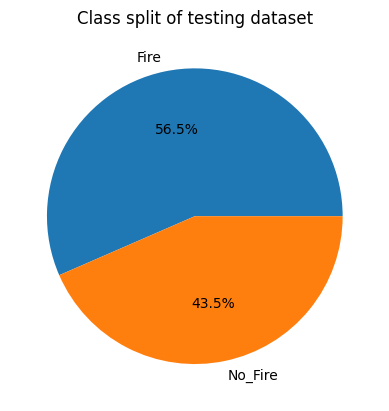

In [ ]:
# Initialize counters for both classes
Fire_count_test = 0
No_Fire_count_test = 0

# Use for loop for counting
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count_test += np.sum(labels == 0)
    No_Fire_count_test += np.sum(labels == 1)

# Sum the total counts
Total_test = Fire_count_test + No_Fire_count_test

# Print out the counts
print(f"{class_names[0]}, Count: {Fire_count_test}")
print(f"{class_names[1]}, Count: {No_Fire_count_test}")
print(f"Total Images: {Total_test}")

# Now calculate the percentages of both classes
percent_Fire_test = Fire_count_test / Total_test
percent_No_Fire_test = No_Fire_count_test / Total_test

# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire_test*100}%')
print(f'Percentage of images with No Fire: {percent_No_Fire_test*100}%')

# Store the percentages in a list
sizes_test = [ percent_Fire_test,percent_No_Fire_test]


# Plot a pie chart of data split
plt.figure()
plt.pie(sizes_test,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of testing dataset')
plt.savefig('test_piechart.png')

In [ ]:
# Create empty list to store labels
test_labels = []

# Use for loop to count
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()
    # Add the labels to the list
    test_labels.extend(labels)

In [ ]:
# Print the number of testing labels
print('Number of testing images: ',len(test_labels))

Number of testing images:  9088


## **Task 2: Function Defining**

In [ ]:
def visualise_samples(dataset, class_names, num_images=9, grid_size=(3, 3), figsize=(10, 10)):
    '''
    Visualises a batch of images from a TensorFlow dataset.

    Inputs:
     dataset: TensorFlow dataset, the dataset containing image-label pairs.
     class_names: list, class labels corresponding to dataset categories.
     num_images: int, number of images to display (default: 9).
     grid_size: tuple, shape of the image grid (default: (3, 3)).
     figsize: tuple, figure size for visualization (default: (10, 10)).

    Returns:
     Prints image
    '''

    #  Create figure
    plt.figure(figsize=figsize)

    # Use for loop to plot
    for images, labels in dataset.take(5):
        # For loop to take num_images
        for i in range(min(num_images, images.shape[0])):
            # Set location of plot on figure
            ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
            # Display the image
            plt.imshow(images[i].numpy().astype("uint8"))
            # Add class names and remove axis
            plt.title(class_names[int(labels[i])])
            plt.axis("off")



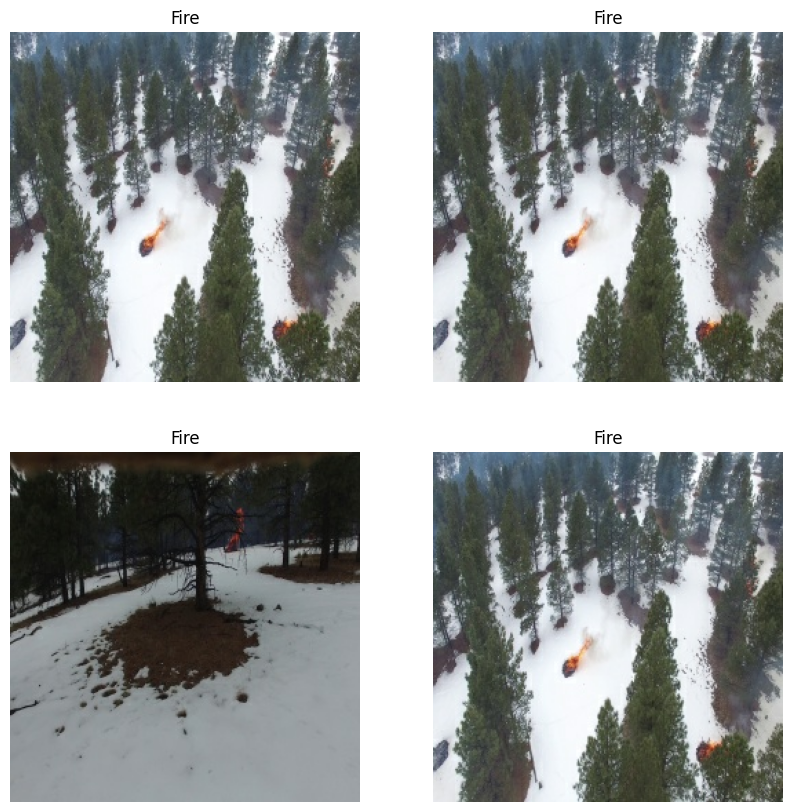

In [ ]:
visualise_samples(raw_test_ds, class_names, num_images=4, grid_size=(2, 2), figsize=(10, 10))
plt.savefig('test_images.svg')

In [ ]:
def binary_evaluation(ds, class_names, modelname, threshold=0.5,title=None):
    '''
    Evaluates a binary classification model and displays a confusion matrix.

    Inputs:
     ds: TensorFlow dataset, dataset containing images and labels.
     class_names: list, class labels corresponding to dataset categories.
     modelname: Keras model, trained model to evaluate.
     threshold: float, decision threshold for binary classification (default: 0.5).

    Returns:
     None (prints evaluation results and displays confusion matrix).
    '''

    # Create empty list for labels
    test_labels = []

    # Collect all labels from dataset
    for images, labels in ds:
        test_labels.extend(labels.numpy())

    print("Evaluate on test data")

    # Evaluate model performance on dataset
    results = modelname.evaluate(ds, return_dict=True)
    print("Test loss, test accuracy:", results)

    # Generate predictions for the dataset
    predictions = modelname.predict(ds)

    # Apply threshold to convert probabilities into binary class labels
    predicted_classes = (predictions >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true=test_labels, y_pred=predicted_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Option for title
    if title is not None:
        plt.title(title)

    # Save Confusion matrix
    plt.savefig(f'Confusion.svg')


def plot_ROC_curve(modelname, test_ds, test_labels,title=None):
    '''
    Plots the ROC curve and calculates the optimal threshold using Youden's J statistic.

    Inputs:
      modelname: Keras model, the trained model to evaluate.
      test_ds: TensorFlow dataset, dataset containing test images and labels.
      test_labels: list or array, true binary labels for the test dataset.

    Returns:
      None (displays the ROC curve and prints the optimal threshold).
    '''

    # Get model predictions for the test dataset
    pred = modelname.predict(test_ds)

    # Calculate the ROC curve values (False Positive Rate, True Positive Rate, and thresholds)
    fpr, tpr, thresholds = roc_curve(test_labels, pred)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])  # X-axis limits (False Positive Rate)
    plt.ylim([0.0, 1.05])  # Y-axis limits (True Positive Rate)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


    # Option for title
    if title is not None:
        plt.title(title)


    # Calculate Youden's J statistic (TPR - FPR)
    J_scores = tpr - fpr

    # Find the index of the optimal threshold (maximum J score)
    optimal_idx = np.argmax(J_scores)

    # Get the optimal threshold value
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print("Optimal Threshold:", optimal_threshold)

    # Save the ROC curve
    plt.savefig(f'ROC.svg')


In [ ]:
# Define metrics
METRICS = [
      keras.metrics.F1Score(name='f1_score',threshold=(0.5)),
      keras.metrics.AUC(name='auc'),
]

## **Task 3: Model loading and testing**

Now the data is loaded in, the model architecture must be defined so that the weights can be loaded in.

In [ ]:
def make_model(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
      summarise: bool, whether to print the model summary (default is False).

    Returns:
      model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32),
      keras.layers.LeakyReLU(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
      model.summary()
      return model
    else:
      return model


In [ ]:
# Define the model
IMG_SIZE = 254
model = make_model(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 306,017 (1.17 MB)

 Trainable params: 305,633 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Move to root directory and load model weights
os.chdir('/')
model.load_weights('binary_rgb.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Now the model is defined and the weights are loaded, we can check that the model is correct by doing a simple evulation on the raw data set...

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.4078 - f1_score: 0.3354 - loss: 1.4466
Test loss, test accuracy: {'auc': 0.9107097387313843, 'f1_score': 0.8652075529098511, 'loss': 1.619876503944397}
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


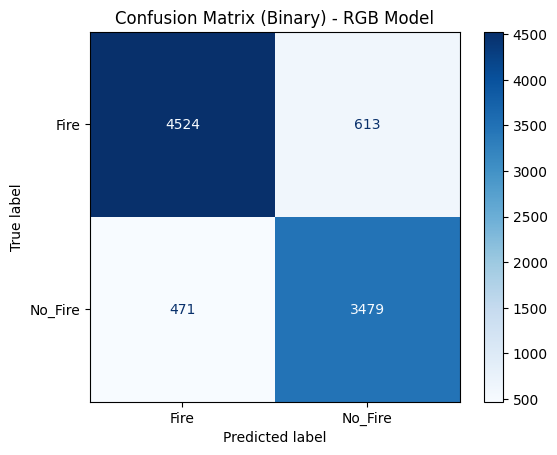

In [ ]:
# Test model weights on raw test data
binary_evaluation(raw_test_ds,class_names,model,title='Confusion Matrix (Binary) - RGB Model')

This is the correct result based on the training for the RGB model.

## **Task 4: Simulating Conditions & Scenarios**

### **Wind**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def wind(ds):
  '''
  Simulate wind knocking the camera out of standard position.

  Inputs:
   ds: TensorFlow dataset, the input dataset containing images.
   IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

  Returns:
   ds: TensorFlow dataset, the augmented dataset with transformations applied.
  '''

  wind_augmentation = tf.keras.Sequential([
        keras.layers.RandomRotation(0.7)])

  ds = ds.map(lambda x, y: (wind_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
  return ds

In [ ]:
test_ds_wind = wind(raw_test_ds)

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - auc: 0.3845 - f1_score: 0.2937 - loss: 1.3161
Test loss, test accuracy: {'auc': 0.852253258228302, 'f1_score': 0.7834135890007019, 'loss': 1.7380772829055786}
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step


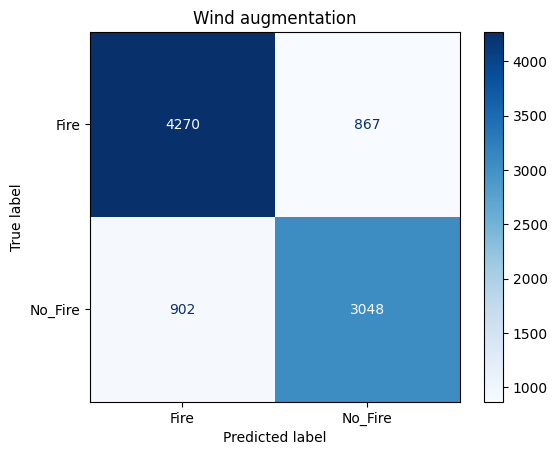

In [ ]:
binary_evaluation(test_ds_wind, class_names, model, title='Wind augmentation')

142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step
Optimal Threshold: 0.0002972993


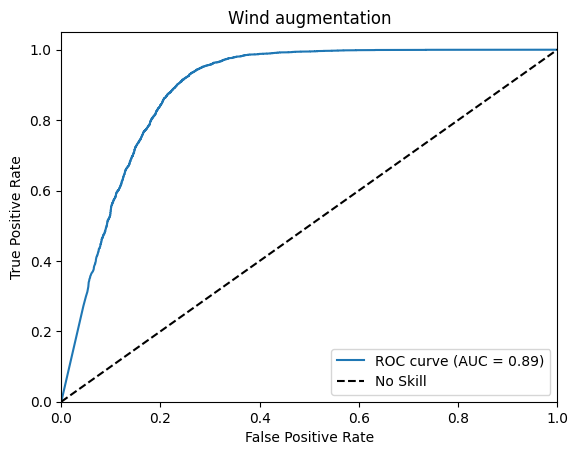

In [ ]:
plot_ROC_curve(model, test_ds_wind, test_labels, title='Wind augmentation')


### **Glare simulation**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def glare(ds):
  '''
  Simulate wind knocking the camera out of standard position.

  Inputs:
   ds: TensorFlow dataset, the input dataset containing images.
   IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

  Returns:
   ds: TensorFlow dataset, the augmented dataset with transformations applied.
  '''

  random_glare = tf.keras.Sequential([
       keras.layers.RandomBrightness([0.2,0.7],value_range=(0, 255),) ])

  ds = ds.map(lambda x, y: (random_glare(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
  return ds

In [ ]:
test_ds_brightness = glare(raw_test_ds)

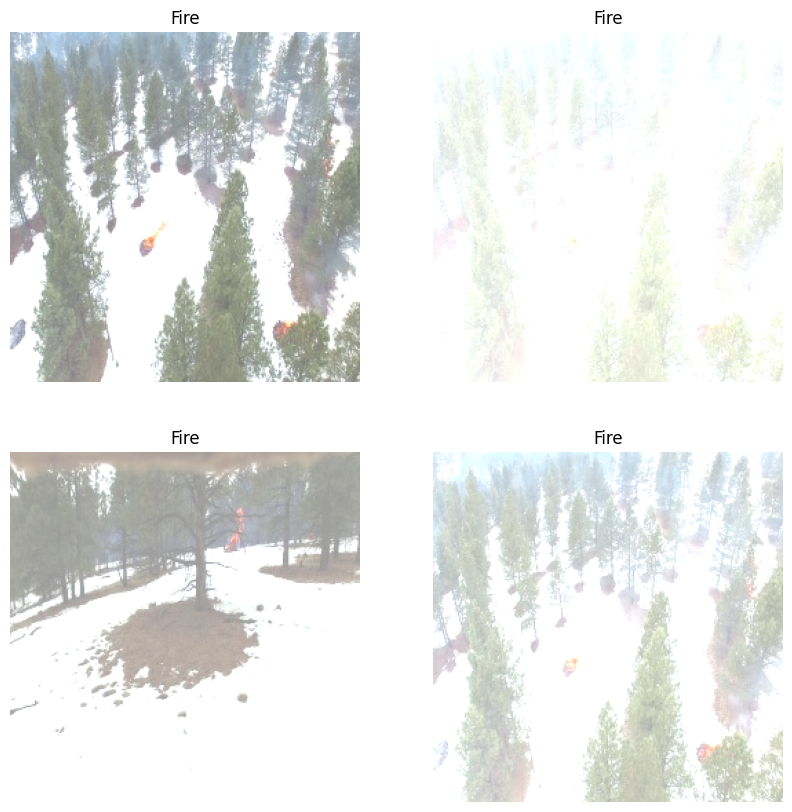

In [ ]:
visualise_samples(test_ds_brightness, class_names, num_images=4, grid_size=(2, 2), figsize=(10, 10))

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - auc: 0.3552 - f1_score: 0.2513 - loss: 4.0176
Test loss, test accuracy: {'auc': 0.7860454320907593, 'f1_score': 0.7498704791069031, 'loss': 2.8123486042022705}
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step


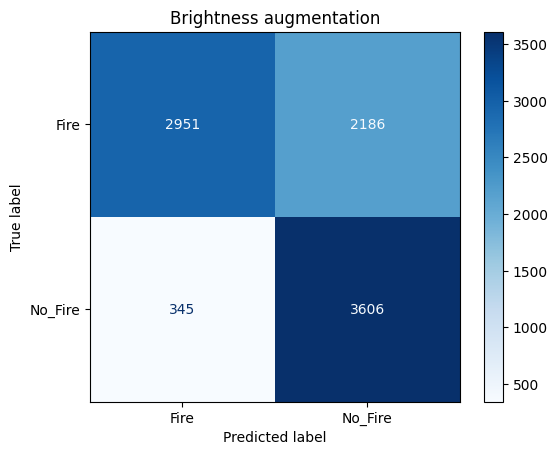

In [ ]:
binary_evaluation(test_ds_brightness, class_names, model, title='Brightness augmentation')

### **Capture Failure**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def camera_failure(ds):
  '''
  Simulate wind knocking the camera out of standard position.

  Inputs:
   ds: TensorFlow dataset, the input dataset containing images.
   IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

  Returns:
   ds: TensorFlow dataset, the augmented dataset with transformations applied.
  '''

  random_camera_failure = tf.keras.Sequential([
       keras.layers.RandomBrightness([0,-0.6],value_range=(0, 255),) ])

  ds = ds.map(lambda x, y: (random_camera_failure(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
  return ds

In [ ]:
test_ds_capture = camera_failure(raw_test_ds)

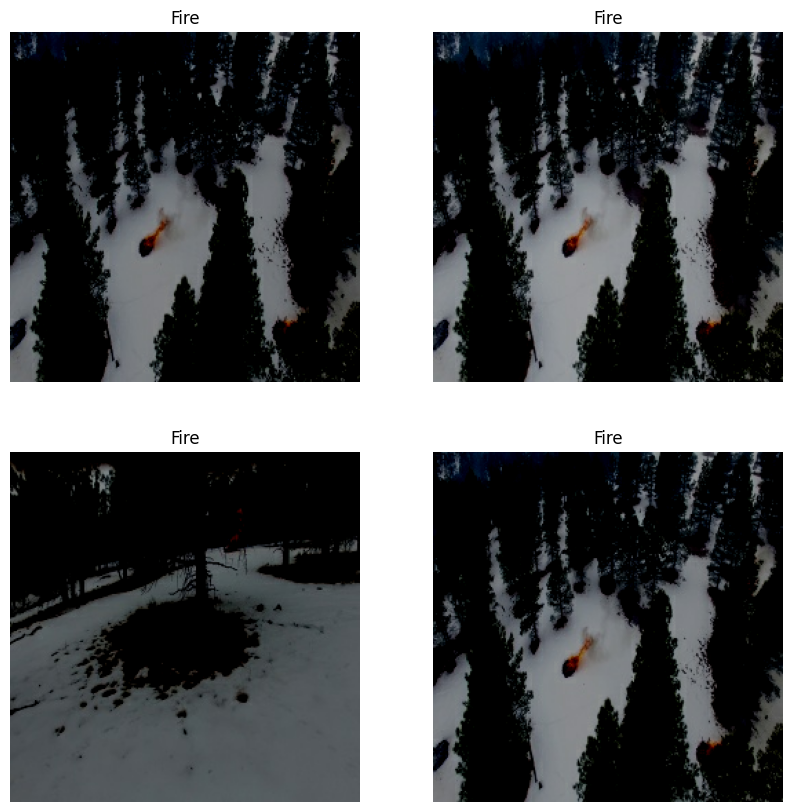

In [ ]:
visualise_samples(test_ds_capture, class_names, num_images=4, grid_size=(2, 2), figsize=(10, 10))

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.3625 - f1_score: 0.2603 - loss: 4.1944
Test loss, test accuracy: {'auc': 0.8123583793640137, 'f1_score': 0.7749292850494385, 'loss': 3.619476318359375}
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


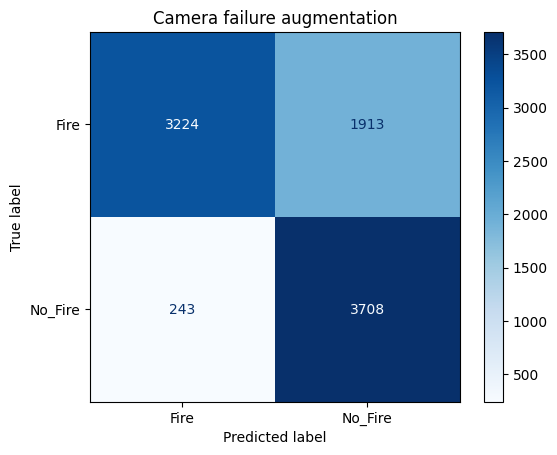

In [ ]:
binary_evaluation(test_ds_capture, class_names, model, title='Camera failure augmentation')

### **Power Failure**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def colour_degeneration(ds):
  '''
  Simulate wind knocking the camera out of standard position.

  Inputs:
   ds: TensorFlow dataset, the input dataset containing images.
   IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

  Returns:
   ds: TensorFlow dataset, the augmented dataset with transformations applied.
  '''

  colour_degeneration = tf.keras.Sequential([
       keras.layers.RandomColorDegeneration(1,value_range=(0, 255),) ])

  ds = ds.map(lambda x, y: (colour_degeneration(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
  return ds

In [ ]:
test_ds_power = colour_degeneration(raw_test_ds)

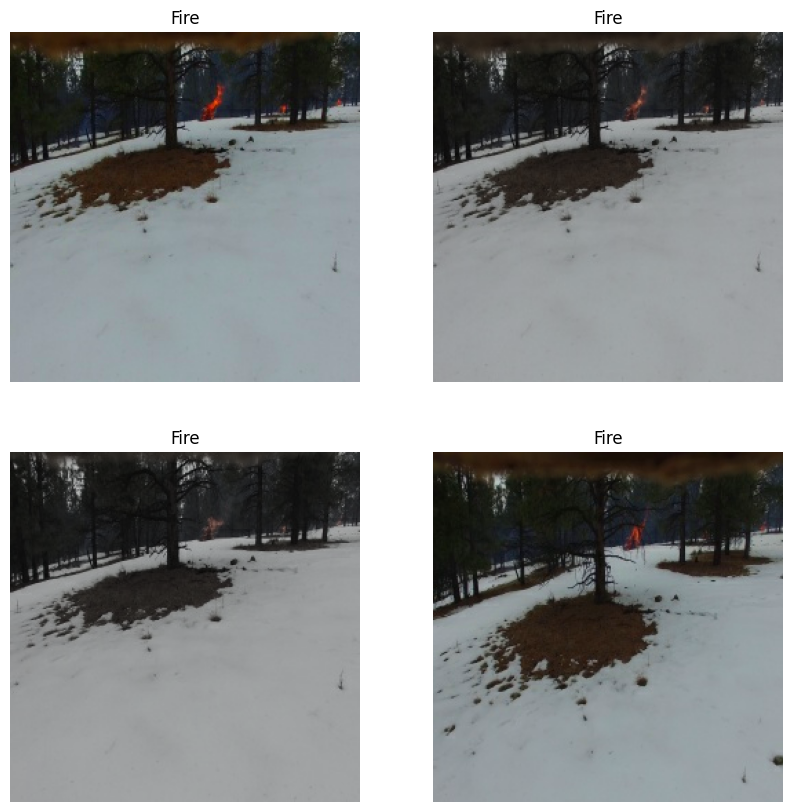

In [ ]:
visualise_samples(test_ds_power, class_names, num_images=4, grid_size=(2, 2), figsize=(10, 10))

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - auc: 0.3508 - f1_score: 0.2503 - loss: 3.4254
Test loss, test accuracy: {'auc': 0.7526757121086121, 'f1_score': 0.6887367367744446, 'loss': 4.339332580566406}
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


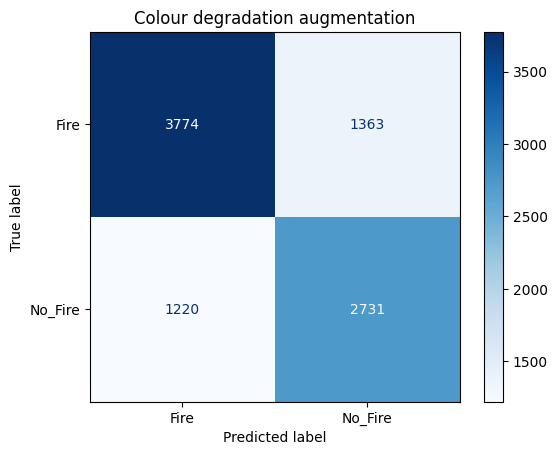

In [ ]:
binary_evaluation(test_ds_power, class_names, model, title='Colour degradation augmentation')

## **Task 5: Final Evaluation**

In [ ]:
def plot_ROC_curve(modelname, test_ds, test_labels,title=None):
    '''
    Plots the ROC curve and calculates the optimal threshold using Youden's J statistic.

    Inputs:
      modelname: Keras model, the trained model to evaluate.
      test_ds: TensorFlow dataset, dataset containing test images and labels.
      test_labels: list or array, true binary labels for the test dataset.

    Returns:
      None (displays the ROC curve and prints the optimal threshold).
    '''

    # Get model predictions for the test dataset
    pred = modelname.predict(test_ds)

    # Calculate the ROC curve values (False Positive Rate, True Positive Rate, and thresholds)
    fpr, tpr, thresholds = roc_curve(test_labels, pred)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])  # X-axis limits (False Positive Rate)
    plt.ylim([0.0, 1.05])  # Y-axis limits (True Positive Rate)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


    # Option for title
    if title is not None:
        plt.title(title)


    # Calculate Youden's J statistic (TPR - FPR)
    J_scores = tpr - fpr

    # Find the index of the optimal threshold (maximum J score)
    optimal_idx = np.argmax(J_scores)

    # Get the optimal threshold value
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print("Optimal Threshold:", optimal_threshold)

    # Save the ROC curve
    plt.savefig(f'ROC.svg')


<ipython-input-482-9e26898b0fbf>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


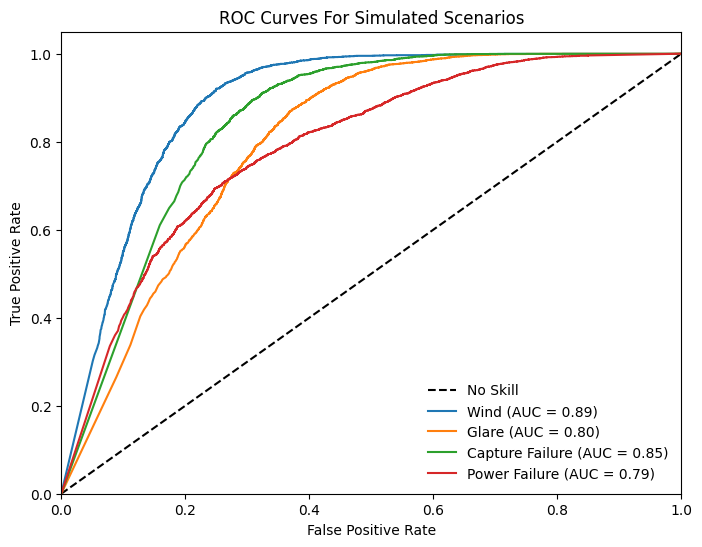

In [ ]:
# Create list of simulation datasets
datasets = [test_ds_wind,test_ds_brightness,test_ds_capture,test_ds_power]

# Create list of names of different simulations
names = ['Wind','Glare','Capture Failure','Power Failure']

# Creat ROC plot
plt.figure(figsize=(8,6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves For Simulated Scenarios')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



for indx,i in enumerate(datasets):
  # Fet model predctions
  pred = model.predict(i,verbose=0)

  # Calculate fpr and tpr
  fpr,tpr,threshold = roc_curve(test_labels,pred)

  # Calculate AUC
  roc_auc = auc(fpr,tpr)

  plt.plot(fpr,tpr, label=f'{names[indx]} (AUC = {roc_auc:0.2f})')


plt.legend(edgecolor='1',loc='lower right')

plt.savefig('ROC-simulations.svg',dpi=300)